# Optimasi *Support Vector Machine* Menggunakan Algoritma Genetika dan *Grid Search* untuk Klasifikasi Kanker Paru-paru pada Citra Magnetic Resonance Imaging

Muhammad Abdul Ghani

123180020

## Koneksi Google Drive

In [17]:
# from google.colab import drive
# import os

# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import Dataset

In [7]:
import os
import cv2

path1, dirs1, cancer = next(os.walk("iCloud://iCloud Drive//Tugas Akhir//app//Lung Cancer//cancer"))
path2, dirs2, normal = next(os.walk("iCloud Drive/Tugas Akhir/app/Lung Cancer/normal/"))

images = []
labels = []
names = []

for n in range(len(normal)):
    img = cv2.imread("/iCloud Drive/Tugas Akhir/app/Lung Cancer/normal/"+normal[n], cv2.IMREAD_GRAYSCALE)
    images.append(img)
    labels.append(0)
    names.append(normal[n])
    
for n in range(len(cancer)):
    img = cv2.imread("/iCloud Drive/Tugas Akhir/app/Lung Cancer/cancer/"+cancer[n], cv2.IMREAD_GRAYSCALE)
    images.append(img)
    labels.append(1)
    names.append(cancer[n])

StopIteration: 

## Ekstraksi Fitur dengan GLCM

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from skimage.feature import greycomatrix, greycoprops
import numpy as np

# Begin Function for Extraction Feature with GLCM 
def calc_glcm(img, img_name, label, props, dists=[5], agls=[0], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img,
                        distances=dists,
                        angles=agls,
                        levels=lvl,
                        symmetric=sym,
                        normed=norm)
    
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    feature.append(img_name)
    feature.append(label)
    for item in glcm_props:
        feature.append(item)
    
    return feature
# End Funtion for Extraction Feature with GLCM 

properties = ['contrast', 'energy', 'correlation', 'dissimilarity', 'homogeneity', 'ASM']
glcm_all = []
for img, name, label in zip(images, names, labels):
    glcm_all.append(
        calc_glcm(img, name, label, props=properties)
    )
    
columns = []
columns.append("name")
columns.append("label")
for name in properties :
    columns.append(name)

## Mengubah Hasil GLCM Menjadi Dataframe

In [20]:
import pandas as pd

# Save DataFrame to CSV 
df = pd.DataFrame(glcm_all, columns=columns)
df = df.sample(frac = 1).reset_index(drop=True)
df.to_csv("/content/drive/My Drive/TA/raw_features.csv")
df.head(10)

,name,label,contrast,energy,correlation,dissimilarity,homogeneity,ASM
0,Malignant case (527).jpg,1,376.117742,0.226697,0.964916,6.238227,0.532662,0.051392
1,Normal case (258).jpg,0,847.935354,0.078727,0.934024,12.929391,0.213398,0.006198
2,Malignant case (470).jpg,1,599.469971,0.070711,0.952713,9.643256,0.303789,0.005000
3,Malignant case (129).jpg,1,701.917792,0.063052,0.941114,10.616402,0.269367,0.003976
4,Malignant case (521).jpg,1,727.610654,0.062906,0.943742,10.575236,0.287932,0.003957
5,Malignant case (454).jpg,1,557.043967,0.066439,0.956456,9.827358,0.306283,0.004414
6,Normal case (407).jpg,0,750.133094,0.070145,0.941310,12.147124,0.204110,0.004920
7,Normal case (284).jpg,0,784.658288,0.199275,0.935638,12.048127,0.305372,0.039711
8,Malignant case (344).jpg,1,577.561444,0.093194,0.954525,9.087748,0.359592,0.008685
9,Malignant case (155).jpg,1,944.081935,0.067201,0.916670,12.442643,0.297335,0.004516


## Split Dataset Menjadi Data Training dan Data Testing

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.svm import SVC
import pandas as pd

# Read CSV 
glcm_df = pd.read_csv("/content/drive/My Drive/TA/raw_features.csv", index_col=0) 

# Create x and y variable
x = glcm_df[glcm_df.columns.drop(['name', 'label'])]
y = glcm_df['label']

# Split Dataset (70% training, 30% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=101)


## Hasil SVM Tanpa Optimasi

In [22]:
svc_model = SVC(kernel='linear', C=1.0)
svc_model.fit(x_train, y_train)
svc_predictions = svc_model.predict(x_test)

print("SVM Accuracy : ", accuracy_score(y_test, svc_predictions))
print("SVM Precision = ", precision_score(y_test, svc_predictions))
print("SVM Recall    = ", recall_score(y_test, svc_predictions))
print("SVM F1 Score  = ", f1_score(y_test, svc_predictions))
print("Error : ", mean_absolute_error(y_test, svc_predictions))

print(classification_report(y_test, svc_predictions))

SVM Accuracy :  0.8333333333333334
SVM Precision =  0.8529411764705882
SVM Recall    =  0.8579881656804734
SVM F1 Score  =  0.8554572271386431
Error :  0.16666666666666666
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       125
           1       0.85      0.86      0.86       169

    accuracy                           0.83       294
   macro avg       0.83      0.83      0.83       294
weighted avg       0.83      0.83      0.83       294



## Confussion Matriks SVM Tanpa Optimasi

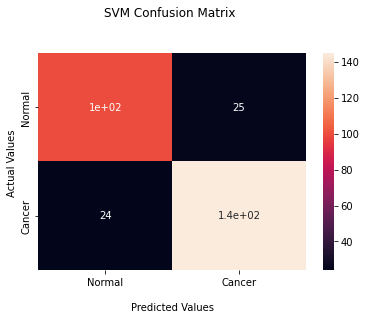

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test, svc_predictions)
plot = sn.heatmap(matrix, annot=True)

plot.set_title('SVM Confusion Matrix \n\n');
plot.set_xlabel('\nPredicted Values')
plot.set_ylabel('Actual Values ');
plot.xaxis.set_ticklabels(['Normal','Cancer'])
plot.yaxis.set_ticklabels(['Normal','Cancer'])
plt.show()

## Mencari Parameter Terbaik dengan Algoritma Grid Search

In [24]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear']}
grid_svm = GridSearchCV(SVC(), hyperparameters, cv=5, verbose=5)

#  'gamma': [10,1,0.1,0.01]
#  'degree': [1, 2, 5, 10],

In [25]:
grid_svm.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.715 total time=   0.1s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.745 total time=   0.1s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.810 total time=   0.1s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.750 total time=   0.1s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.765 total time=   0.1s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.737 total time=   0.2s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.730 total time=   0.4s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.759 total time=   0.4s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.757 total time=   0.2s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.779 total time=   0.3s
[CV 1/5] END ................C=1, kernel=linear;, score=0.723 total time=   2.5s
[CV 2/5] END ................C=1, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear']},
             verbose=5)

In [26]:
print('Used Kernel : ', grid_svm.best_estimator_.kernel)
print('Best C      : ', grid_svm.best_estimator_.C)
print('Best Score  : ', grid_svm.best_score_)

cvalue = grid_svm.best_estimator_.C
# print('Best Gamma  : ', grid_svm.best_estimator_.gamma)
# print('Best Degree : ', grid_svm.best_estimator_.degree)

Used Kernel :  linear
Best C      :  1000
Best Score  :  0.8346285959639331


## Hasil GridSearch-SVM

In [27]:
from sklearn.pipeline import make_pipeline
svm_optimal = SVC(C=cvalue,kernel='linear')
svm_optimal.fit(x_train, y_train)
# ,gamma=0.01

SVC(C=1000, kernel='linear')

In [28]:
grid_svm_predict = svm_optimal.predict(x_test)
print (classification_report(y_test, grid_svm_predict))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       125
           1       0.90      0.86      0.88       169

    accuracy                           0.86       294
   macro avg       0.86      0.86      0.86       294
weighted avg       0.86      0.86      0.86       294



In [29]:
print("GridSearch-SVM Accuracy  = ", accuracy_score(y_test, grid_svm_predict))
print("GridSearch-SVM Precision = ", precision_score(y_test, grid_svm_predict))
print("GridSearch-SVM Recall    = ", recall_score(y_test, grid_svm_predict))
print("GridSearch-SVM F1 Score  = ", f1_score(y_test, grid_svm_predict))
print("Error : ", mean_absolute_error(y_test, grid_svm_predict))

grid_svm = SVC(kernel='linear', C=cvalue)
# , gamma=0.01

GridSearch-SVM Accuracy  =  0.8605442176870748
GridSearch-SVM Precision =  0.8950617283950617
GridSearch-SVM Recall    =  0.8579881656804734
GridSearch-SVM F1 Score  =  0.8761329305135952
Error :  0.13945578231292516


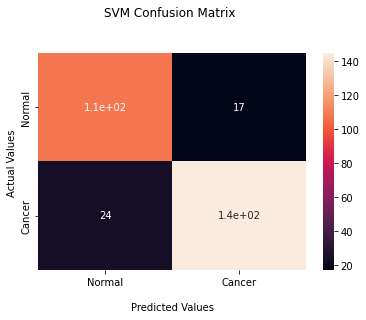

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test, grid_svm_predict)
plot = sn.heatmap(matrix, annot=True)

plot.set_title('SVM Confusion Matrix \n\n');
plot.set_xlabel('\nPredicted Values')
plot.set_ylabel('Actual Values ');
plot.xaxis.set_ticklabels(['Normal','Cancer'])
plot.yaxis.set_ticklabels(['Normal','Cancer'])
plt.show()

## Seleksi Fitur dengan GA

In [31]:
import numpy as np
# Inisiasi
size = 20
n_feat = 6
n_parents = 10
mutation_rate = 0.1
n_gen = 10

def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
        print(population)
    return population

def fitness_score(population):
    scores = []
    for chromosome in population: 
        grid_svm.fit(x_train.iloc[:,chromosome],y_train)
        predictions = grid_svm.predict(x_test.iloc[:,chromosome])
        scores.append(accuracy_score(y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        child=pop_after_sel[i]
        child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if np.random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

def generations(size,n_feat,n_parents,mutation_rate,n_gen,
                X_train,X_test, y_train, y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        # print("generasi ke : "+ str(i+1) +", accuracy : "+ str(scores[0]))
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo, best_score

chromo,score=generations(size, n_feat, n_parents, mutation_rate, n_gen,
                         x_train, x_test, y_train, y_test)

[array([ True,  True,  True,  True,  True, False])]
[array([ True,  True,  True,  True,  True, False]), array([ True,  True,  True,  True,  True, False])]
[array([ True,  True,  True,  True,  True, False]), array([ True,  True,  True,  True,  True, False]), array([ True,  True, False,  True,  True,  True])]
[array([ True,  True,  True,  True,  True, False]), array([ True,  True,  True,  True,  True, False]), array([ True,  True, False,  True,  True,  True]), array([ True,  True,  True, False,  True,  True])]
[array([ True,  True,  True,  True,  True, False]), array([ True,  True,  True,  True,  True, False]), array([ True,  True, False,  True,  True,  True]), array([ True,  True,  True, False,  True,  True]), array([ True,  True,  True,  True, False,  True])]
[array([ True,  True,  True,  True,  True, False]), array([ True,  True,  True,  True,  True, False]), array([ True,  True, False,  True,  True,  True]), array([ True,  True,  True, False,  True,  True]), array([ True,  True,  Tru

In [32]:
for i in chromo:
    grid_svm.fit(x_train.iloc[:,i],y_train)
    predictions = grid_svm.predict(x_test.iloc[:,i])
    accuracy = accuracy_score(y_test, predictions)
    
    print("chromo : ", i)
    print("accuracy : ", accuracy)

chromo :  [ True  True  True  True  True  True]
accuracy :  0.8605442176870748
chromo :  [ True  True  True  True  True False]
accuracy :  0.8571428571428571
chromo :  [False  True False  True False False]
accuracy :  0.8299319727891157
chromo :  [ True  True  True False  True False]
accuracy :  0.9115646258503401
chromo :  [False  True  True  True  True False]
accuracy :  0.9829931972789115
chromo :  [False  True  True  True  True  True]
accuracy :  0.9829931972789115
chromo :  [False  True  True  True  True False]
accuracy :  0.9829931972789115
chromo :  [False  True  True  True  True  True]
accuracy :  0.9829931972789115
chromo :  [False  True  True  True  True  True]
accuracy :  0.9829931972789115
chromo :  [False  True  True False  True  True]
accuracy :  0.9761904761904762


In [33]:
pchromo = []
pscore = 0

for i in chromo:
    grid_svm.fit(x_train.iloc[:,i],y_train)
    predictions = grid_svm.predict(x_test.iloc[:,i])
    accuracy = accuracy_score(y_test, predictions)
    if accuracy > pscore:
        pchromo = i
        pscore = accuracy

In [34]:
print(pchromo)
print(pscore)

[False  True  True  True  True False]
0.9829931972789115


In [35]:
dffeature = pd.DataFrame(pchromo, columns=['feature'])
dffeature.to_csv("/content/drive/My Drive/TA/best_features.csv")

## Hasil GridSearch-GA-SVM

In [36]:
ga_model = SVC(kernel='linear', C=cvalue)
ga_model.fit(x_train.iloc[:,pchromo], y_train)
ga_predictions = ga_model.predict(x_test.iloc[:,pchromo])

print("GridSearch-GA-SVM Accuracy  = ", accuracy_score(y_test, ga_predictions))
print("GridSearch-GA-SVM Precision = ", precision_score(y_test, ga_predictions))
print("GridSearch-GA-SVM Recall    = ", recall_score(y_test, ga_predictions))
print("GridSearch-GA-SVM F1 Score  = ", f1_score(y_test, ga_predictions))
print("Error : ", mean_absolute_error(y_test, ga_predictions))

print(classification_report(y_test, ga_predictions))

GridSearch-GA-SVM Accuracy  =  0.9829931972789115
GridSearch-GA-SVM Precision =  1.0
GridSearch-GA-SVM Recall    =  0.9704142011834319
GridSearch-GA-SVM F1 Score  =  0.9849849849849849
Error :  0.017006802721088437
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       125
           1       1.00      0.97      0.98       169

    accuracy                           0.98       294
   macro avg       0.98      0.99      0.98       294
weighted avg       0.98      0.98      0.98       294



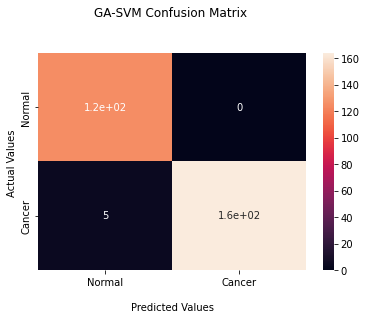

In [37]:
matrix = confusion_matrix(y_test, ga_predictions)
plot = sn.heatmap(matrix, annot=True)

plot.set_title('GA-SVM Confusion Matrix \n\n');
plot.set_xlabel('\nPredicted Values')
plot.set_ylabel('Actual Values ');
plot.xaxis.set_ticklabels(['Normal','Cancer'])
plot.yaxis.set_ticklabels(['Normal','Cancer'])
plt.show()

## KFold Cross Validation

In [38]:
from sklearn.model_selection import KFold, cross_validate

cv = KFold(n_splits=30, random_state=45, shuffle=True)
ga_scores = cross_validate(ga_model, x_test, ga_predictions, scoring=['accuracy', 'precision', 'recall', 'f1'],cv=cv)
svc_scores = cross_validate(svc_model, x_test, grid_svm_predict, scoring=['accuracy', 'precision', 'recall', 'f1'],cv=cv)

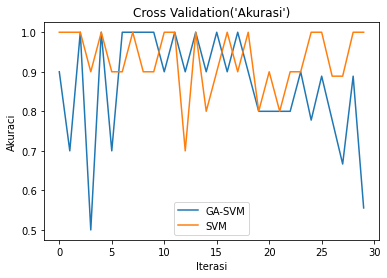

In [39]:
x = [i for i in range(30)]
y1 = list(map(float, ga_scores['test_accuracy']))
y2 = list(map(float, svc_scores['test_accuracy']))

plt.plot(x, y1, label = "GA-SVM")
plt.plot(x, y2, label = "SVM")
plt.xlabel("Iterasi")
plt.ylabel("Akuraci")
plt.title("Cross Validation('Akurasi')")
plt.legend()
plt.show()

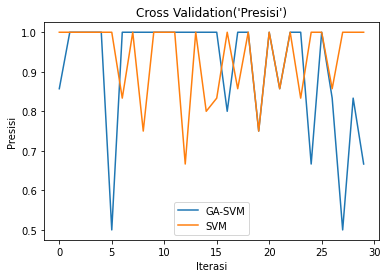

In [40]:
y1 = list(map(float, ga_scores['test_precision']))
y2 = list(map(float, svc_scores['test_precision']))

plt.plot(x, y1, label = "GA-SVM")
plt.plot(x, y2, label = "SVM")
plt.xlabel("Iterasi")
plt.ylabel("Presisi")
plt.title("Cross Validation('Presisi')")
plt.legend()
plt.show()

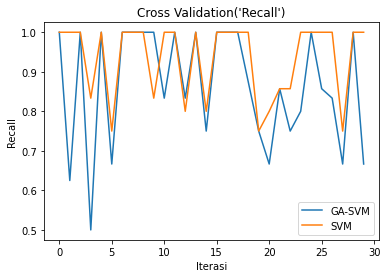

In [41]:
y1 = list(map(float, ga_scores['test_recall']))
y2 = list(map(float, svc_scores['test_recall']))

plt.plot(x, y1, label = "GA-SVM")
plt.plot(x, y2, label = "SVM")
plt.xlabel("Iterasi")
plt.ylabel("Recall")
plt.title("Cross Validation('Recall')")
plt.legend()
plt.show()

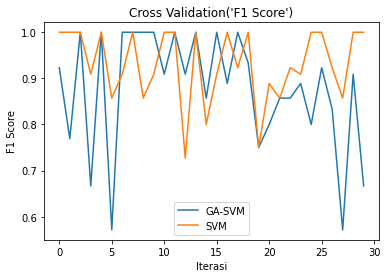

In [42]:
y1 = list(map(float, ga_scores['test_f1']))
y2 = list(map(float, svc_scores['test_f1']))

plt.plot(x, y1, label = "GA-SVM")
plt.plot(x, y2, label = "SVM")
plt.xlabel("Iterasi")
plt.ylabel("F1 Score")
plt.title("Cross Validation('F1 Score')")
plt.legend()
plt.show()

In [43]:
for i in range(10):
    print(y1[i])

0.923076923076923
0.7692307692307693
1.0
0.6666666666666666
1.0
0.5714285714285715
1.0
1.0
1.0
1.0


In [44]:
for i in range(10):
    print(y2[i])

1.0
1.0
1.0
0.9090909090909091
1.0
0.8571428571428571
0.9090909090909091
1.0
0.8571428571428571
0.9090909090909091
